In [29]:
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, 'util')
import vcpi_util

### Init device

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(device)

2.2.1+cu121
cuda:0


### Settings

In [31]:
BATCH_SIZE = 64
EPOCKS = 20
IMG_SIZE = 32
EPOCHS = 60

PATH_TRAINING_SET = "data/train_images/GTSRB/Final_Training/Images"
PATH_TEST_SET = "data/test_images"

### Model Building Aux

Esta secção define várias funções auxiliares utilizadas para treinar e avaliar os modelos:
- A função `train` é responsável por treinar o modelo durante várias épocas, calculando a perda e a precisão tanto nos dados de treinamento quanto nos de validação. 

- A classe `Early_Stopping` é utilizado para interromper o treinamento prematuramente se não houver melhoria na perda de validação num determinado número de épocas.

- A função `evaluate` é responsável por avaliar o desempenho do modelo num conjunto de dados de teste, calculando a precisão geral do modelo.

- A classe `Conv` define a arquitetura da rede utilizada, composta por várias camadas convolucionais e totalmente conectadas.

In [32]:
def train(model, train_loader, val_loader, epochs, loss_fn, optimizer,
           scheduler, early_stopper, save_prefix = 'model'):

    history = {}
    history['accuracy'] = []
    history['val_acc'] = []
    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.detach()
            correct += (predicted == targets).sum()

        model.eval()
        v_correct = 0
        val_loss = 0.0
        with torch.no_grad():
            for i,t in val_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)
                
                #with torch.no_grad():
                val_loss += loss_fn(o, t)

                v_correct += (p == t).sum()

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        v_accuracy = 100 * v_correct / len(val_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Accuracy: {accuracy:0.4f}; Val Loss: {val_loss:0.6f}; Val Acc: {v_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['val_acc'].append(v_accuracy.cpu().numpy())
        history['val_loss'].append(val_loss.cpu().detach().numpy())
        history['loss'].append(epoch_loss.cpu().detach().numpy())
 
        ###### Saving ######
        if val_loss < best_val_loss :
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
                },
                f'models/{save_prefix}.pt')

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)


def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):

            # forward pass, compute the output of the model for the current batch
            outputs = model(images.to(device))

            # "max" returns a namedtuple (values, indices) where values is the maximum 
            # value of each row of the input tensor in the given dimension dim; 
            # indices is the index location of each maximum value found (argmax).
            # the argmax effectively provides the predicted class number        
            _, preds = torch.max(outputs, dim=1)

            correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


class Conv(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)


        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)
        

    def forward(self, x):    
        
        # input = (bs, 3, 32, 32)
        x = self.conv1(x) # -> (bs, 16, 30, 30)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x) # -> (bs, 32, 14, 14)
        
        x = self.conv3(x) # -> (bs, 48, 12, 12)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x) # -> (bs, 48, 5, 5)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 5 * 5 = 1200)
        x = self.fc1(x)        # -> (bs, num_classes)

        return(x)


class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False
    


def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes)) 

def build_confusion_matrix2(model, dataset, class_names):
    preds = []
    ground_truth = []

    for images, targets in dataset:
        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    num_classes = len(class_names) if class_names else len(set(ground_truth))
    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes))




## Model with Transform
### Data Loading

Nesta secção, completamos a preparação dos dados, carregando os conjuntos de dados de treinamento, validação e teste com as suas respetivas transformações.

É feito um shuffle nos dados de treino e é colocado 30% dos dados de treino como dados de validação. As transformações na variável *base_transform* são realizadas em todos os datasets (treino, teste e validação) e as transformações na variável *transform* são realizadas exclusivamente no dataset de treino.  

In [33]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.3,p=1.0),
        v2.RandomAffine(degrees=4, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.2, contrast=0.4, saturation=0.3),
])


base_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.dataset)
  

In [34]:
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

generator1 = torch.Generator().manual_seed(42)
rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3], generator=generator1)

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE)

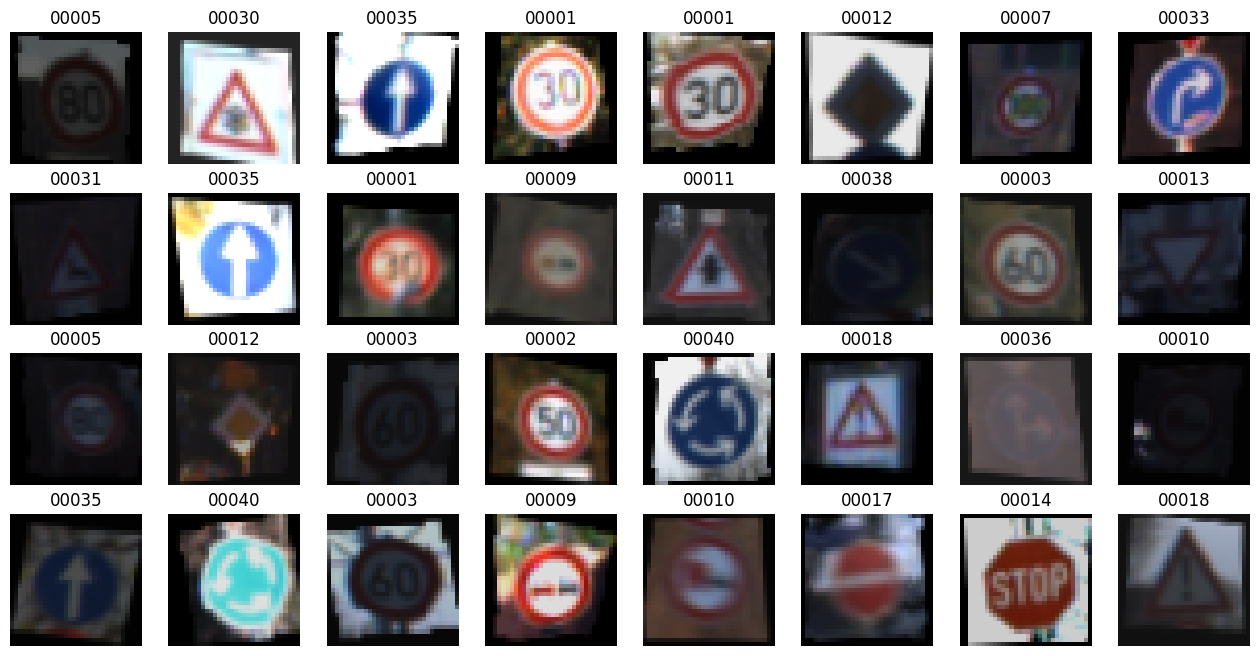

<Figure size 640x480 with 0 Axes>

In [35]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

### Model Training

Nesta secção realizamos o treinamento e a avaliação do modelo. Primeiro, inicializamos o modelo e o movemos para o dispositivo de computação adequado. Em seguida, configuramos o otimizador do tipo Adam, a função de perda e o critério de parada antecipada. Depois, treinamos o modelo chamando a função *train*, passando os carregadores de dados de treinamento e validação, juntamente com o número de épocas e o prefixo para salvar o modelo.

In [36]:
model = Conv(len(rtrain_set.classes))
model.to(device)

optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

In [37]:
history = train(
    model, train_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model18fr')

Epoch: 000; Loss: 0.014711; Accuracy: 74.2923; Val Loss: 0.001250; Val Acc: 98.7247; Elapsed time: 64.1627
Epoch: 001; Loss: 0.002612; Accuracy: 95.4931; Val Loss: 0.000796; Val Acc: 98.5037; Elapsed time: 70.3362
Epoch: 002; Loss: 0.001524; Accuracy: 97.1873; Val Loss: 0.000358; Val Acc: 99.3794; Elapsed time: 72.8706
Epoch: 003; Loss: 0.001157; Accuracy: 97.8431; Val Loss: 0.000503; Val Acc: 99.0308; Elapsed time: 71.4482
Epoch: 004; Loss: 0.001034; Accuracy: 98.1054; Val Loss: 0.000362; Val Acc: 99.2263; Elapsed time: 72.3249
Epoch: 005; Loss: 0.000748; Accuracy: 98.5937; Val Loss: 0.000223; Val Acc: 99.6429; Elapsed time: 72.6896
Epoch: 006; Loss: 0.000792; Accuracy: 98.5317; Val Loss: 0.000277; Val Acc: 99.4304; Elapsed time: 75.9178
Epoch: 007; Loss: 0.000723; Accuracy: 98.5536; Val Loss: 0.000234; Val Acc: 99.6344; Elapsed time: 68.6187
Epoch: 008; Loss: 0.000583; Accuracy: 98.8669; Val Loss: 0.000212; Val Acc: 99.5664; Elapsed time: 67.5775
Epoch: 009; Loss: 0.000515; Accuracy:

### Test Model


Por fim, depois do modelo ser treinado, avaliamos o desempenho do modelo no conjunto de dados de teste usando a função *evaluate*, obtendo, assim, o resultado da precisão do nosso modelo perante o dataset de teste.

In [38]:
evaluate(model, test_loader)

0.9862232804298401